In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True)

In [2]:
# вариант 4
p = {
    'lambda': 7.92,     # Интенсивность входящего потока заявок
    'nu': 3.6,          # Интенсивность обслуживания заявки
    'r': 3,             # Количество каналов
    'm': 1              # Возможная длина очереди
}

Граф состояний процесса
![Граф состояний](graph.png "Граф состояний")
<p>S0 - нет бревен, все машины свободны</p>
<p>S1 - в системе 1 бревно, 1 машина занята, 0 бревен в очереди</p>
<p>S2 - в системе 2 бревна, 2 машины заняты, 0 бревен в очереди</p>
<p>S3 - в системе 3 бревна, 3 машины заняты, 0 бревен в очереди</p>
<p>S4 - в системе 4 бревна, 3 машины заняты, 1 бревно в очереди</p>

In [3]:
transition_matrix = np.array([
    np.array([-p['lambda'], p['nu'], 0, 0, 0]),
    np.array([p['lambda'], -(p['nu']+p['lambda']), 2*p['nu'], 0, 0]),
    np.array([0, p['lambda'], -(2*p['nu']+p['lambda']), 3*p['nu'], 0]),
    np.array([0, 0, p['lambda'], -(3*p['nu']+p['lambda']), 3*p['nu']]),
    np.array([0, 0, 0, p['lambda'], -3*p['nu']])
])

transition_matrix

array([[ -7.92,   3.6 ,   0.  ,   0.  ,   0.  ],
       [  7.92, -11.52,   7.2 ,   0.  ,   0.  ],
       [  0.  ,   7.92, -15.12,  10.8 ,   0.  ],
       [  0.  ,   0.  ,   7.92, -18.72,  10.8 ],
       [  0.  ,   0.  ,   0.  ,   7.92, -10.8 ]])

In [4]:
def solve_stationary_probability(transition_matrix):
    n = len(transition_matrix)
    A = transition_matrix
    probability_dist = np.ones((1, n))

    A = np.vstack((A, probability_dist))
    B = np.zeros(n + 1)
    B[-1] = 1

    p = np.linalg.lstsq(A, B, rcond=1)[0]
    return p

In [5]:
stationary = solve_stationary_probability(transition_matrix)
"Стационарные вероятности: ", stationary

('Стационарные вероятности: ',
 array([0.11499, 0.25299, 0.27829, 0.20408, 0.14966]))

In [6]:
def average_machines(stationary_prob):
    parts = []
    for i in range(p['r']):
        parts.append([stationary_prob[i]])
    parts.append(stationary_prob[-(len(stationary_prob) - p['r']):])

    working_mean = sum([sum(a) * idx for idx, a in enumerate(parts)])

    parts = parts[::-1]
    not_working_mean = sum([sum(a) * idx for idx, a in enumerate(parts)])

    return working_mean, not_working_mean

In [7]:
working, not_working = average_machines(stationary)
"Среднее число работающих и простаивающих машин: %.2f и %.2f: " % (working, not_working)

'Среднее число работающих и простаивающих машин: 1.87 и 1.13: '

In [8]:
work_coef = working / p['r']
idle_coef = not_working / p['r']

In [9]:
"Коэффициент загрузки: %.2f" % (work_coef * 100)

'Коэффициент загрузки: 62.36'

In [10]:
"Коэффициент простаивания: %.2f" % (idle_coef * 100)

'Коэффициент простаивания: 37.64'

In [11]:
def average_timbers(stationary_prob):
    parts = [stationary_prob[:len(stationary_prob) - p['m']]]
    for prob in stationary_prob[len(stationary_prob) - p['m']:]:
        parts.append([prob])
    timbers_mean = sum([sum(a) * idx for idx, a in enumerate(parts)])
    return timbers_mean

"Среднее число бревен в очереди: %.2f" % average_timbers(stationary)

'Среднее число бревен в очереди: 0.15'

In [12]:
def vector_stdev(va, vb):
    return np.sqrt(sum((b - a)**2 for b, a in zip(vb, va)))

In [13]:
def euler_method(transition_matrix, start_condition, stationary_prob):
    current_t = 0.0
    h = 0.02
    steps = [start_condition, ]

    while vector_stdev(stationary_prob, steps[-1]) > 1e-3:
        line = []
        for i in range(len(start_condition)):
            line.append(steps[-1][i] + h * sum([x * steps[-1][j] for j, x in enumerate(transition_matrix[i])]))
        steps.append(line)
        current_t += h

    return np.array(steps)

start_cond = np.array([1, 0, 0, 0, 0])
euler_steps = euler_method(transition_matrix, start_cond, stationary)

Изменение вероятностей со временем

In [14]:
euler_steps[:10]

array([[1.     , 0.     , 0.     , 0.     , 0.     ],
       [0.8416 , 0.1584 , 0.     , 0.     , 0.     ],
       [0.7197 , 0.25521, 0.02509, 0.     , 0.     ],
       [0.62407, 0.31403, 0.05793, 0.00397, 0.     ],
       [0.54783, 0.34887, 0.09101, 0.01166, 0.00063],
       [0.48617, 0.36837, 0.12127, 0.02185, 0.00234],
       [0.43568, 0.37797, 0.14767, 0.03338, 0.0053 ],
       [0.39389, 0.38116, 0.17009, 0.04542, 0.00944],
       [0.35894, 0.38023, 0.18884, 0.0574 , 0.0146 ],
       [0.32946, 0.37667, 0.20436, 0.06897, 0.02053]])

In [15]:
def non_stationary_plot(steps, labels):
    xmin = 0
    dx = 0.02
    xmax = dx * len(steps)

    xlist = np.arange(xmin, xmax, dx)
    for i, ylist in enumerate(steps.T):
        plt.plot(xlist, ylist, label=labels[i])

    plt.gca().yaxis.grid(True)
    plt.yticks([x for x in np.arange(0, 1, 0.1)])
    plt.legend()
    plt.show()

Вероятности состояний системы

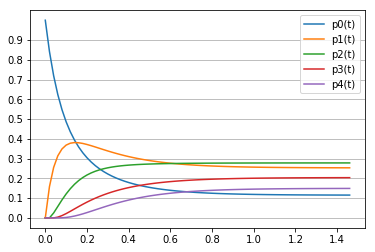

In [16]:
non_stationary_plot(euler_steps, labels=['p0(t)', 'p1(t)', 'p2(t)', 'p3(t)', 'p4(t)'])

In [17]:
def non_stationary_coefs(steps):
    coef_steps = []
    i = 0

    while i < len(steps):
        coef_work = sum(k * steps[i][k] for k in range(0, p['r']))
        coef_work += p['r'] * sum(steps[i][k] for k in range(p['r'], p['r'] + p['m'] + 1))
        coef_work /= p['r']

        coef_idle = sum(k * steps[i][p['r'] - k] for k in range(1, p['r'] + 1)) / p['r']

        coef_steps.append([coef_work, coef_idle])
        i += 1

    return np.array(coef_steps)

coefficients = non_stationary_coefs(euler_steps)

Изменение коэффициентов со временем

In [18]:
coefficients[:10]

array([[0.     , 1.     ],
       [0.0528 , 0.9472 ],
       [0.1018 , 0.8982 ],
       [0.14727, 0.85273],
       [0.18926, 0.81074],
       [0.22783, 0.77217],
       [0.26311, 0.73689],
       [0.29531, 0.70469],
       [0.32463, 0.67537],
       [0.35131, 0.64869]])

Коэффициенты загрузки и простоя машин в цехе

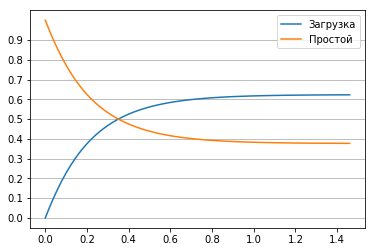

In [19]:
non_stationary_plot(coefficients, labels=['Загрузка', 'Простой'])